In [1]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

     |████████████████████████████████| 573kB 30.8MB/s 
     |████████████████████████████████| 3.7MB 39.7MB/s 
     |████████████████████████████████| 1.0MB 58.4MB/s 
     |████████████████████████████████| 870kB 45.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=0efcd3492424a913b5b417a332c2728bed8202a4daeb582b4a395ed8b58dbebd
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your

In [0]:
import time
import torch
import logging
import transformers
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader



In [3]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

logging.getLogger("transformers").setLevel(logging.ERROR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = '/content/drive/My Drive/Colab Notebooks/Toxic Comments/'
df = pd.read_csv(data_path + 'train.csv')
df = df.drop(['id'], axis = 1)
df = df.sample(frac=1, random_state = 42)

toxic = df[df.toxic == 1]
non_toxic = df[df.toxic != 1]
non_toxic = non_toxic.sample(n = 15000)
df = pd.concat([toxic, non_toxic])
df = df.sample(frac=1, random_state = 42)

train, val, test = df[:20000].values, df[20000:25000].values, df[25000:].values
print('Train Size', train.shape)
print('Val Size', val.shape)
print('Test Size', test.shape)


Train Size (20000, 7)
Val Size (5000, 7)
Test Size (5294, 7)


In [0]:
class ToxicDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.dataframe = dataframe
        self.max_len = max_len
        self.sep_id = tokenizer.encode(['[SEP]'], add_special_tokens=False)
        self.pad_id = tokenizer.encode(['[PAD]'], add_special_tokens=False)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe[idx]
        text = row[0]
        targets = torch.tensor(list(row[1:]))
        encoded = tokenizer.encode(text, add_special_tokens=True)[:self.max_len-1]
        if encoded[-1] != self.sep_id[0]:
            encoded = encoded + self.sep_id
        padded = encoded + self.pad_id * (self.max_len - len(encoded))
        padded = torch.tensor(padded)
        labels = torch.Tensor(list(row[1:]))
        return padded, labels

In [0]:
train_dataset = ToxicDataset(train, 84)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = ToxicDataset(val, 84)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = ToxicDataset(test, 84)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [0]:
def evaluate(model, data):
    actual, predictions = [], []
    with torch.no_grad():
        for features, targets in data:
            features = features.to(device)
            targets = targets.to(device)
            scores, attentions = model(features)
            sigmoid_out = torch.sigmoid(scores)
            prediction = torch.as_tensor(sigmoid_out > 0.5, dtype=torch.int32)
            predictions.extend(prediction.view(-1).tolist())
            actual.extend(targets.long().view(-1).tolist())
    assert len(actual) == len(predictions)
    print('Macro F1 Score', f1_score(actual, predictions, average = 'macro'))

In [0]:
class BertNN(nn.Module):
    def __init__(self, hidden_size):
        super(BertNN, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained(pretrained_weights, output_attentions = True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 6)

    def forward(self, ex):
        _, pooled_output, attentions = self.bert_model(ex)
        pooled_output = self.dropout(pooled_output)
        fc_out = self.fc(pooled_output)
        return fc_out, attentions

# Training

In [0]:
model = BertNN(768)
model = model.to(device)
loss_function = nn.BCEWithLogitsLoss()
loss_function = loss_function.to(device)
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False)
MAX_EPOCHS = 1

max_grad_norm = 1.0
warmup_proportion = 0.1
num_training_steps  = len(train_dataloader) * MAX_EPOCHS
num_warmup_steps = num_training_steps * warmup_proportion
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)



In [9]:
for epoch in range(MAX_EPOCHS):
    epoch_loss = 0
    start_time = time.time()
    for idx, (features, targets) in enumerate(train_dataloader):
        model.zero_grad()
        features = features.to(device)
        targets = targets.to(device)
        scores, attentions = model(features)
        loss = loss_function(scores, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    if device == 'cuda':
        torch.cuda.empty_cache()
    time_taken = round((time.time() - start_time)/60, 2)
    print(f'Epoch {epoch + 1} | Loss - {epoch_loss} | Time Taken - {time_taken} min')
    evaluate(model, val_dataloader)

evaluate(model, test_dataloader)

Epoch 1 | Loss - 117.66990756988525 | Time Taken - 5.69 min
Macro F1 Score 0.9054722697945694
Macro F1 Score 0.9085067089794184


# Test Dataset Analysis

In [0]:
data = test_dataloader
actual, predictions = [], []
sentences = []
pred = []
gold = []
with torch.no_grad():
    for features, targets in data:
        features = features.to(device)
        targets = targets.to(device)
        scores, attentions = model(features)
        sigmoid_out = torch.sigmoid(scores)
        prediction = torch.as_tensor(sigmoid_out > 0.5, dtype=torch.int32)

        predictions.extend(prediction.view(-1).tolist())
        actual.extend(targets.long().view(-1).tolist())

        for i, feat in enumerate(features):
            full_strs = tokenizer.convert_ids_to_tokens(feat)
            full_str = ''
            for strs in full_strs:
                if strs not in ['[PAD]','[SEP]','[CLS]']:
                        full_str += strs + " "
            sentences.append(full_str)
            pred.append(prediction[i])
            gold.append(targets[i])
            

In [27]:
print('Macro F1 Score for test dataset is', f1_score(actual, predictions, average = 'macro'))

Macro F1 Score for test dataset is 0.9082910500730648


In [28]:
import itertools
from sklearn.metrics import f1_score, classification_report

idx_to_tag =  {0 :'non_toxic', 1: 'toxic'}
preds_label = []
gold_label = []
for i in range(len(sentences)):
  preds_label.append([idx_to_tag[idx] for idx in pred[i].tolist()])
  gold_label.append([idx_to_tag[idx] for idx in gold[i].tolist()])

g_merged = list(itertools.chain(*gold_label))
p_merged = list(itertools.chain(*preds_label))
from sklearn.metrics import f1_score, classification_report
print(classification_report(g_merged, p_merged, digits=3))

              precision    recall  f1-score   support

   non_toxic      0.963     0.972     0.967     26002
       toxic      0.868     0.831     0.849      5762

    accuracy                          0.946     31764
   macro avg      0.916     0.901     0.908     31764
weighted avg      0.946     0.946     0.946     31764



# Error Analysis

In [18]:
count=0
sents = []
preds = []
golds = []

for i in range(len(sentences)):
  if pred[i].tolist() != gold[i].tolist():
    count+=1
    preds.append(pred[i].tolist())
    golds.append(gold[i].tolist())
    sents.append(sentences[i])
    # print the incorrect prediction for error analysis
    print(sentences[i])
    print(pred[i])
    print(gold[i])

print("The total number of incorrect prediction:", count)

who ##ops , sorry about that , it was an honest mistake as my first rev ##ert came at the same time as the one rev ##ert ##ing van ##dal ##isi ##m , i thought you were being a smart ars ##e who was rev ##ert ##ing the page back to its van ##dal ##isi ##m . 
tensor([1, 0, 0, 0, 0, 0], dtype=torch.int32)
tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
" a friend wu ##h ##wu ##zd ##at and hell ##bus . when ' s the wedding . now don ' t expect me to come , but don ' t worry , i ' ll watch you on the news , on the next 9 / 11 , ha ha ha ha ha ##aa ##aa ##aa . this time it will be a nuclear event . you can count on that . wu ##h ##wu ##zd ##at , can you feel 
tensor([0, 0, 0, 0, 0, 0], dtype=torch.int32)
tensor([1., 0., 0., 0., 0., 0.], device='cuda:0')
laid back ! he ' s the bloody enemy ! i hate his guts . he bull ##ies and con ##sp ##ire ##s against me all the time . i think that he is an abs ##olt ##e bastard . he is po ##mp ##ous and he does al ##ot because he wants to own the project

# Attention Analysis

In [73]:
print(len(attentions))
print(attentions[-1].shape) # batch_size, num_heads, sequence_length, sequence_length

12
torch.Size([14, 12, 84, 84])


In [81]:
last_layer_attn = attentions[-1] # because the batch size is 1 so we squeeze the batch dimension.
print(last_layer_attn.shape)

torch.Size([14, 12, 84, 84])


In [75]:
weights = last_layer_attn.cpu()
weights = weights[0,:,:,0]
print(weights.shape) #[number of head, sequence length]

torch.Size([12, 84])


In [0]:
# Plot the last sentence in test dataset to process attention weight visualization 
weights = weights.detach().numpy()
input_tokens = sentences[-1].split(" ")

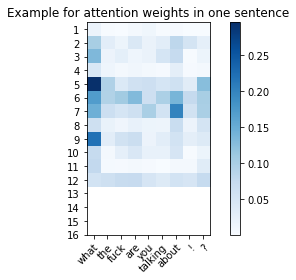

In [80]:
import numpy as np
import matplotlib.pyplot as plt
weights = np.array(weights)[:,0:len(input_tokens)-1]

fig, ax = plt.subplots()
im = ax.imshow(weights,cmap=plt.cm.Blues)
ax.set_xticks(np.arange(len(input_tokens)-1))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(input_tokens)
ax.set_yticklabels([i for i in range(1,17)])
plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Example for attention weights in one sentence")
fig.tight_layout()
plt.show()